# Mixture Density Networks

Mixture density networks (MDN) (Bishop, 1994) are a class
of models obtained by combining a conventional neural network with a
mixture density model.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import inferpy as inf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from scipy import stats
from sklearn.model_selection import train_test_split

In [2]:
def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
    """Plots the mixture of Normal models to axis=ax comp=True plots all
    components of mixture model
    """
    x = np.linspace(-10.5, 10.5, 250)
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = stats.norm.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Normal ' + str(i))
    ax.plot(x, final, label='Mixture of Normals ' + label)
    ax.legend(fontsize=13)


def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """Draws samples from mixture model.

    Returns 2 d array with input X and sample from prediction of mixture model.
    """
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, means, std_devs) in enumerate(
                    zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(means[index], std_devs[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
    return samples

## Data

We use the same toy data from
[David Ha's blog post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/), where he explains MDNs. It is an inverse problem where
for every input $x_n$ there are multiple outputs $y_n$.

Size of features in training data: (5000, 1)
Size of output in training data: (5000,)


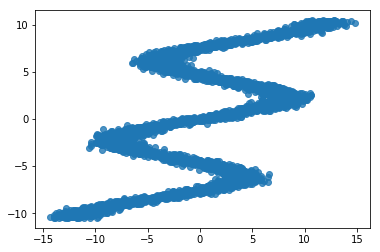

In [3]:
def build_toy_dataset(N):
    y_data = np.random.uniform(-10.5, 10.5, N).astype(np.float32)
    r_data = np.random.normal(size=N).astype(np.float32)    # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((N, 1))
    return x_data, y_data

import random 

tf.random.set_random_seed(42)
np.random.seed(42)
random.seed(42)

#inf.setseed(42)

N = 5000    # number of data points
D = 1    # number of features
K = 20    # number of mixture components

x_train, y_train = build_toy_dataset(N)


print("Size of features in training data: {}".format(x_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
sns.regplot(x_train, y_train, fit_reg=False)
plt.show()

## Fitting a Neural Network

We could try to fit a neural network over this data set. However, for each x value in this dataset there are multiple y values. So, it poses problems on the use of standard neural networks.

Let's first define the neural network. We use `tf.keras.layers` to construct neural networks. We specify a three-layer network with 15 hidden units for each hidden layer.

In [4]:
nnetwork = tf.keras.Sequential([
    tf.keras.layers.Dense(15, activation=tf.nn.relu),
    tf.keras.layers.Dense(15, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=None),
])

The following code fits the neural network to the data

In [5]:
lossfunc = lambda y_out, y: tf.nn.l2_loss(y_out-y)
nnetwork.compile(tf.train.AdamOptimizer(0.1), lossfunc)
nnetwork.fit(x=x_train, y=y_train, epochs=3000)

Epoch 1/3000
5000/5000 [==============================] - 0s 45us/sample - loss: 386.4314
Epoch 2/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 360.6320
Epoch 3/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 363.7711
Epoch 4/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.7580
Epoch 5/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 362.9175
Epoch 6/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 367.5114
Epoch 7/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 362.0606
Epoch 8/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 363.0019
Epoch 9/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 356.8691
Epoch 10/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 362.5977
Epoch 11/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 362.6654
Epoch 12

5000/5000 [==============================] - 0s 24us/sample - loss: 365.3756
Epoch 92/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.7722
Epoch 93/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 359.9051
Epoch 94/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 363.9165
Epoch 95/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 358.5944
Epoch 96/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 363.4026
Epoch 97/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 369.6835
Epoch 98/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 357.8619
Epoch 99/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 360.9243
Epoch 100/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 357.7770
Epoch 101/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 360.6161
Epoch 102/3

5000/5000 [==============================] - 0s 24us/sample - loss: 361.5762
Epoch 181/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 358.2845
Epoch 182/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 359.9036
Epoch 183/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 358.9626
Epoch 184/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.2619
Epoch 185/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 359.6323
Epoch 186/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 360.6942
Epoch 187/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 359.7944
Epoch 188/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.4884
Epoch 189/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 360.0248
Epoch 190/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 360.1299
Epo

5000/5000 [==============================] - 0s 23us/sample - loss: 360.2516
Epoch 270/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 356.9954
Epoch 271/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 360.5367
Epoch 272/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 360.8090
Epoch 273/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 356.2687
Epoch 274/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 359.4300
Epoch 275/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 359.2045
Epoch 276/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 359.4302
Epoch 277/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 360.5305
Epoch 278/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 357.5075
Epoch 279/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 357.9059
Epo

5000/5000 [==============================] - 0s 23us/sample - loss: 358.2147
Epoch 359/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 398.8592
Epoch 360/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 417.2266
Epoch 361/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 409.5501
Epoch 362/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 410.4172
Epoch 363/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 410.8046
Epoch 364/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 390.8121
Epoch 365/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 385.9911
Epoch 366/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 391.7461
Epoch 367/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 383.2742
Epoch 368/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 384.5028
Epo

5000/5000 [==============================] - 0s 23us/sample - loss: 373.3968
Epoch 448/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.2936
Epoch 449/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.4030
Epoch 450/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.2538
Epoch 451/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.0103
Epoch 452/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.6649
Epoch 453/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.5229
Epoch 454/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.0835
Epoch 455/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 370.1670
Epoch 456/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.5744
Epoch 457/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.3479
Epo

5000/5000 [==============================] - 0s 23us/sample - loss: 367.7844
Epoch 537/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.3225
Epoch 538/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.0941
Epoch 539/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.5719
Epoch 540/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.8429
Epoch 541/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.7153
Epoch 542/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.1670
Epoch 543/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.7416
Epoch 544/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.4814
Epoch 545/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.4161
Epoch 546/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 367.0143
Epo

5000/5000 [==============================] - 0s 24us/sample - loss: 365.9758
Epoch 626/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.4163
Epoch 627/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.5126
Epoch 628/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.4803
Epoch 629/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.5902
Epoch 630/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.8897
Epoch 631/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.3787
Epoch 632/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.4548
Epoch 633/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.7721
Epoch 634/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.0932
Epoch 635/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.1808
Epo

5000/5000 [==============================] - 0s 23us/sample - loss: 365.7129
Epoch 715/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.6544
Epoch 716/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.9034
Epoch 717/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.0646
Epoch 718/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 372.4277
Epoch 719/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 372.3520
Epoch 720/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.3448
Epoch 721/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.2596
Epoch 722/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.8929
Epoch 723/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.8881
Epoch 724/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.1760
Epo

5000/5000 [==============================] - 0s 23us/sample - loss: 368.2370
Epoch 804/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.7576
Epoch 805/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 371.3358
Epoch 806/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.0161
Epoch 807/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 365.5587
Epoch 808/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.5792
Epoch 809/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.8092
Epoch 810/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.4598
Epoch 811/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 375.1556
Epoch 812/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.0557
Epoch 813/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.0112
Epo

5000/5000 [==============================] - 0s 23us/sample - loss: 369.3707
Epoch 893/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.4029
Epoch 894/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.8500
Epoch 895/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.3030
Epoch 896/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.5785
Epoch 897/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.1184
Epoch 898/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.5557
Epoch 899/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.7447
Epoch 900/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.7607
Epoch 901/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.8604
Epoch 902/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 366.4111
Epo

5000/5000 [==============================] - 0s 23us/sample - loss: 367.8887
Epoch 982/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.5389
Epoch 983/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 369.5765
Epoch 984/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.8232
Epoch 985/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 366.5608
Epoch 986/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.1123
Epoch 987/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 367.7385
Epoch 988/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.5848
Epoch 989/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.9463
Epoch 990/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 366.2832
Epoch 991/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.9836
Epo

5000/5000 [==============================] - 0s 23us/sample - loss: 371.3492
Epoch 1070/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 366.3703
Epoch 1071/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.5543
Epoch 1072/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.6085
Epoch 1073/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 373.6031
Epoch 1074/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 373.8305
Epoch 1075/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.5461
Epoch 1076/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.2250
Epoch 1077/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.5239
Epoch 1078/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.8007
Epoch 1079/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 367.2902
Epoch 1158/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.1410
Epoch 1159/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.9635
Epoch 1160/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 363.1337
Epoch 1161/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.9191
Epoch 1162/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 370.0975
Epoch 1163/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.4040
Epoch 1164/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.9211
Epoch 1165/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 366.0803
Epoch 1166/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.8028
Epoch 1167/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 364.8357
Epoch 1246/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.2632
Epoch 1247/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 364.0458
Epoch 1248/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 370.5610
Epoch 1249/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.5132
Epoch 1250/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 372.7020
Epoch 1251/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.8038
Epoch 1252/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.4610
Epoch 1253/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.8442
Epoch 1254/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.2648
Epoch 1255/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 38

5000/5000 [==============================] - 0s 23us/sample - loss: 371.5488
Epoch 1334/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.0516
Epoch 1335/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 362.8458
Epoch 1336/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 373.2430
Epoch 1337/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.8567
Epoch 1338/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.8571
Epoch 1339/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 365.0390
Epoch 1340/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 374.8090
Epoch 1341/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 373.4404
Epoch 1342/3000
5000/5000 [==============================] - 0s 25us/sample - loss: 365.8871
Epoch 1343/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 36

5000/5000 [==============================] - 0s 22us/sample - loss: 368.2322
Epoch 1422/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 367.1210
Epoch 1423/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 366.5681
Epoch 1424/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.0887
Epoch 1425/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.6116
Epoch 1426/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.9121
Epoch 1427/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.2509
Epoch 1428/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.7859
Epoch 1429/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.6055
Epoch 1430/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.1428
Epoch 1431/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 369.3731
Epoch 1510/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.7905
Epoch 1511/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 375.3489
Epoch 1512/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 375.7790
Epoch 1513/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.4737
Epoch 1514/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.9232
Epoch 1515/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 364.6058
Epoch 1516/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.7615
Epoch 1517/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.7844
Epoch 1518/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.5851
Epoch 1519/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 37

5000/5000 [==============================] - 0s 22us/sample - loss: 367.9779
Epoch 1598/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 373.6565
Epoch 1599/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 367.0457
Epoch 1600/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 363.7423
Epoch 1601/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 365.5896
Epoch 1602/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.9638
Epoch 1603/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 371.1983
Epoch 1604/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.6557
Epoch 1605/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.7766
Epoch 1606/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.9552
Epoch 1607/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 374.7107
Epoch 1686/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 363.6745
Epoch 1687/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 364.9267
Epoch 1688/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.7271
Epoch 1689/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 374.4830
Epoch 1690/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.5517
Epoch 1691/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.9878
Epoch 1692/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.8755
Epoch 1693/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.8770
Epoch 1694/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.2700
Epoch 1695/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 368.5053
Epoch 1774/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.7982
Epoch 1775/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.4264
Epoch 1776/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 369.4518
Epoch 1777/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.3001
Epoch 1778/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.1418
Epoch 1779/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 364.3663
Epoch 1780/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.6376
Epoch 1781/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.8757
Epoch 1782/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.9493
Epoch 1783/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 367.7128
Epoch 1862/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.0379
Epoch 1863/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.2115
Epoch 1864/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 373.2278
Epoch 1865/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.6020
Epoch 1866/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 372.9684
Epoch 1867/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 365.6027
Epoch 1868/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.6705
Epoch 1869/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.0165
Epoch 1870/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 367.0558
Epoch 1871/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 368.0141
Epoch 1950/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.7886
Epoch 1951/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.8293
Epoch 1952/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.0656
Epoch 1953/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 373.9300
Epoch 1954/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.5248
Epoch 1955/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.5208
Epoch 1956/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.0193
Epoch 1957/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.8832
Epoch 1958/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.6804
Epoch 1959/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 365.2711
Epoch 2038/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.6286
Epoch 2039/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.4722
Epoch 2040/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.0018
Epoch 2041/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.4485
Epoch 2042/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.8887
Epoch 2043/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 365.4111
Epoch 2044/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.5675
Epoch 2045/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 367.8825
Epoch 2046/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 368.1218
Epoch 2047/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 372.4994
Epoch 2126/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.0179
Epoch 2127/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.5543
Epoch 2128/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 363.0718
Epoch 2129/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 378.3727
Epoch 2130/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.9228
Epoch 2131/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 368.5379
Epoch 2132/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 362.3777
Epoch 2133/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 370.1328
Epoch 2134/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.0338
Epoch 2135/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 363.0575
Epoch 2214/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.8834
Epoch 2215/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 366.7501
Epoch 2216/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.6241
Epoch 2217/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.8609
Epoch 2218/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 372.3177
Epoch 2219/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.6889
Epoch 2220/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 371.3183
Epoch 2221/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 377.1761
Epoch 2222/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.6121
Epoch 2223/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 370.2400
Epoch 2302/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.8824
Epoch 2303/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.2567
Epoch 2304/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.2199
Epoch 2305/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.5001
Epoch 2306/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 371.3360
Epoch 2307/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 365.9546
Epoch 2308/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.3121
Epoch 2309/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.5051
Epoch 2310/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.5991
Epoch 2311/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 366.8294
Epoch 2390/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 374.2563
Epoch 2391/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.8005
Epoch 2392/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.2845
Epoch 2393/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 365.8962
Epoch 2394/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.6187
Epoch 2395/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.6797
Epoch 2396/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.6021
Epoch 2397/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.9696
Epoch 2398/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.6882
Epoch 2399/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 367.5142
Epoch 2478/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 375.5824
Epoch 2479/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.4066
Epoch 2480/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 363.2780
Epoch 2481/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.8302
Epoch 2482/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.9096
Epoch 2483/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.4708
Epoch 2484/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.7052
Epoch 2485/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 367.3698
Epoch 2486/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 368.3577
Epoch 2487/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 37

5000/5000 [==============================] - 0s 23us/sample - loss: 372.5135
Epoch 2566/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.9664
Epoch 2567/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.4768
Epoch 2568/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.4168
Epoch 2569/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.5092
Epoch 2570/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.8247
Epoch 2571/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 374.3184
Epoch 2572/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.9318
Epoch 2573/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.6064
Epoch 2574/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.7648
Epoch 2575/3000
5000/5000 [==============================] - 0s 24us/sample - loss: 36

5000/5000 [==============================] - 0s 23us/sample - loss: 370.5477
Epoch 2654/3000
5000/5000 [==============================] - 0s 25us/sample - loss: 373.9799
Epoch 2655/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.0731
Epoch 2656/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.2454
Epoch 2657/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 368.2312
Epoch 2658/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 367.5103
Epoch 2659/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 369.2706
Epoch 2660/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 369.8390
Epoch 2661/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 365.0606
Epoch 2662/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.5960
Epoch 2663/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 37

5000/5000 [==============================] - 0s 23us/sample - loss: 367.8495
Epoch 2742/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 367.8732
Epoch 2743/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.3897
Epoch 2744/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.3300
Epoch 2745/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.6868
Epoch 2746/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.1159
Epoch 2747/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.7794
Epoch 2748/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.7987
Epoch 2749/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 364.9721
Epoch 2750/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 367.4975
Epoch 2751/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 37

5000/5000 [==============================] - 0s 23us/sample - loss: 369.4533
Epoch 2830/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 365.4134
Epoch 2831/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.6881
Epoch 2832/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 369.4405
Epoch 2833/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 365.8598
Epoch 2834/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.7565
Epoch 2835/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 366.8833
Epoch 2836/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 368.4339
Epoch 2837/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 371.9681
Epoch 2838/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 364.8234
Epoch 2839/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 37

5000/5000 [==============================] - 0s 23us/sample - loss: 367.6681
Epoch 2918/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 365.6293
Epoch 2919/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 367.6542
Epoch 2920/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 363.9689
Epoch 2921/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 373.4659
Epoch 2922/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.5800
Epoch 2923/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 368.8550
Epoch 2924/3000
5000/5000 [==============================] - 0s 22us/sample - loss: 368.4813
Epoch 2925/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 370.1347
Epoch 2926/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 369.9247
Epoch 2927/3000
5000/5000 [==============================] - 0s 23us/sample - loss: 37

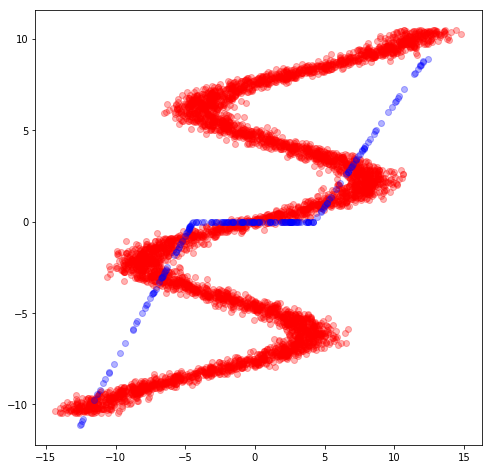

In [6]:
sess = tf.keras.backend.get_session()
x_test, _ = build_toy_dataset(200)          
y_test = sess.run(nnetwork(x_test))

plt.figure(figsize=(8, 8))
plt.plot(x_train,y_train,'ro',x_test,y_test,'bo',alpha=0.3)
plt.show()

It can be seen, the neural network is not able to fit this data.

## Mixture Density Network (MDN)

We use a MDN with a mixture of 20 normal distributions parameterized by a
feedforward network. That is, the membership probabilities and
per-component means and standard deviations are given by the output of a
feedforward network.


We define our probabilistic model using InferPy constructs. Specifically, we use the `MixtureGaussian` distribution, where the the parameters of this network are provided by the feedforwrad network.

In [7]:
def neural_network(X):
    """loc, scale, logits = NN(x; theta)"""
    # 2 hidden layers with 15 hidden units
    net = tf.keras.layers.Dense(15, activation=tf.nn.relu)(X)
    net = tf.keras.layers.Dense(15, activation=tf.nn.relu)(net)
    locs = tf.keras.layers.Dense(K, activation=None)(net)
    scales = tf.keras.layers.Dense(K, activation=tf.exp)(net)
    logits = tf.keras.layers.Dense(K, activation=None)(net)
    return locs, scales, logits


@inf.probmodel
def mdn():
    with inf.datamodel():
        x = inf.Normal(loc = tf.ones([D]), scale = 1.0, name="x")
        locs, scales, logits = neural_network(x)
        y = inf.MixtureGaussian(locs, scales, logits=logits, name="y")
    
m = mdn()


Note that we use the `MixtureGaussian` random variable. It collapses
out the membership assignments for each data point and makes the model
differentiable with respect to all its parameters. It takes a
list as input—denoting the probability or logits for each
cluster assignment—as well as `components`, which are lists of loc and scale values.

For more background on MDNs, take a look at
[Christopher Bonnett's blog post](http://cbonnett.github.io/MDN.html) or at Bishop (1994).

## Inference

Next we train the MDN model. For details, see the documentation about
[Inference in Inferpy](https://inferpy.readthedocs.io/projects/develop/en/develop/notes/guideinference.html)

In [8]:
@inf.probmodel
def qmodel():
        return;

VI = inf.inference.VI(qmodel(), epochs=4000)
m.fit({"y": y_train, "x":x_train}, VI)


 0 epochs	 129578.296875....................
 200 epochs	 113866.8046875....................
 400 epochs	 110405.765625....................
 600 epochs	 108311.9296875....................
 800 epochs	 107741.84375....................
 1000 epochs	 106996.3359375....................
 1200 epochs	 106747.328125....................
 1400 epochs	 106299.640625....................
 1600 epochs	 106157.328125....................
 1800 epochs	 106087.8125....................
 2000 epochs	 106019.1875....................
 2200 epochs	 105955.0703125....................
 2400 epochs	 105751.9765625....................
 2600 epochs	 105717.4609375....................
 2800 epochs	 105693.375....................
 3000 epochs	 105676.3984375....................
 3200 epochs	 105664.40625....................
 3400 epochs	 105655.578125....................
 3600 epochs	 105648.265625....................
 3800 epochs	 105639.09375....................

After training, we can now see how the same network embbeded in a mixture model is able to perfectly capture the training data.

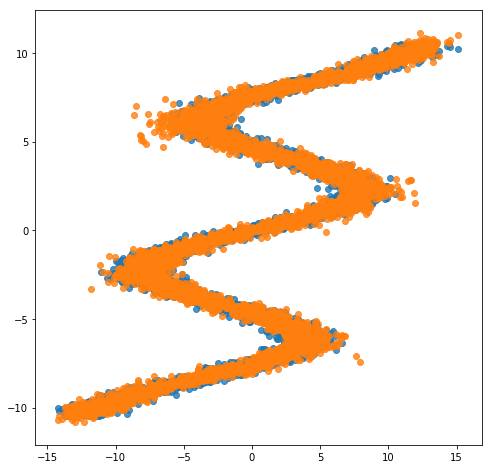

In [9]:
X_test, y_test = build_toy_dataset(N)
y_pred = m.posterior_predictive(["y"], data = {"x": X_test}).sample()

plt.figure(figsize=(8, 8))
sns.regplot(X_test, y_test, fit_reg=False)
sns.regplot(X_test, y_pred, fit_reg=False)
plt.show()

## Acknowledgments

This tutorial is inspired by [David Ha's blog post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) and [Edward's tutorial](http://edwardlib.org/tutorials/mixture-density-network).